# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'SDT', #'SDT', 'vanilla'
    },
    'data': {
        'number_of_variables': 9, 
        'num_classes': 2,
        'categorical_indices': [0,1,2,3],
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': 5, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'random_decision_tree_trained',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [1024, 1024, 256, 2048, 2048],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.3, 0.3, 0.3, 0.3, 0.3],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.0001,
        'loss': 'binary_crossentropy', #mse; soft_mse; binary_crossentropy; soft_binary_crossentropy; 'binary_accuracy'
        'metrics': ['soft_binary_crossentropy', 'binary_accuracy'],
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 3, # 1=standard representation; 2=sparse representation with classification for variables; 3=softmax to select classes (n top probabilities)
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
        'soft_labels': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2,3) #3=autoencoder dimensionality reduction
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 7,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable


In [4]:
tf.__version__

'2.5.2'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type == 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 3 and dt_type == 'SDT'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var9_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_cat0-1-2-3_depth5_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense1024-1024-256-2048-2048_drop0.3-0.3-0.3-0.3-0.3e500b256_adam
lNetSize5000_numLNets10000_var9_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_cat0-1-2-3_depth5_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
       
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              config) for network_parameters_row in network_parameters.values)          
    del parallel
    
    base_model = generate_base_model(config)  
    
    #def initialize_network_wrapper(config, lambda_net, base_model):
    #    lambda_net.initialize_network(config, base_model)
    
    #parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    #_ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    #del parallel
    
    #def initialize_target_function_wrapper(config, lambda_net):
    #    lambda_net.initialize_target_function(config)
    
    #parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    #_ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    #del parallel
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    
    if False:
        lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
        lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_train_with_valid = load_lambda_nets(config_train, n_jobs=n_jobs)
        lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

        _, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)   
        
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=7)]: Done 1038 tasks      | elapsed:    6.8s
[Parallel(n_jobs=7)]: Done 9892 tasks      | elapsed:   10.6s
[Parallel(n_jobs=7)]: Done 10000 out of 10000 | elapsed:   10.7s finished


## Data Inspection

In [12]:
lambda_net_dataset_train.shape

(8955, 1593)

In [13]:
lambda_net_dataset_valid.shape

(995, 1593)

In [14]:
lambda_net_dataset_test.shape

(50, 1593)

In [15]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f7v0,f7v1,f7v2,f7v3,f7v4,f7v5,f7v6,f7v7,f7v8,f8v0,f8v1,f8v2,f8v3,f8v4,f8v5,f8v6,f8v7,f8v8,f9v0,f9v1,f9v2,f9v3,f9v4,f9v5,f9v6,f9v7,f9v8,f10v0,f10v1,f10v2,f10v3,f10v4,f10v5,f10v6,f10v7,...,wb_1309,wb_1310,wb_1311,wb_1312,wb_1313,wb_1314,wb_1315,wb_1316,wb_1317,wb_1318,wb_1319,wb_1320,wb_1321,wb_1322,wb_1323,wb_1324,wb_1325,wb_1326,wb_1327,wb_1328,wb_1329,wb_1330,wb_1331,wb_1332,wb_1333,wb_1334,wb_1335,wb_1336,wb_1337,wb_1338,wb_1339,wb_1340,wb_1341,wb_1342,wb_1343,wb_1344,wb_1345,wb_1346,wb_1347,wb_1348,wb_1349,wb_1350,wb_1351,wb_1352,wb_1353,wb_1354,wb_1355,wb_1356,wb_1357,wb_1358,wb_1359,wb_1360,wb_1361,wb_1362,wb_1363,wb_1364,wb_1365,wb_1366,wb_1367,wb_1368,wb_1369,wb_1370,wb_1371,wb_1372,wb_1373,wb_1374,wb_1375,wb_1376,wb_1377,wb_1378,wb_1379,wb_1380,wb_1381,wb_1382,wb_1383,wb_1384,wb_1385,wb_1386,wb_1387,wb_1388,wb_1389,wb_1390,wb_1391,wb_1392,wb_1393,wb_1394,wb_1395,wb_1396,wb_1397,wb_1398,wb_1399,wb_1400,wb_1401,wb_1402,wb_1403,wb_1404,wb_1405,wb_1406,wb_1407,wb_1408
6671,6671.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.186,-0.085,0.134,0.428,0.250,-0.885,0.032,-0.792,0.249,0.226,-0.423,0.212,0.314,0.237,0.118,0.328,0.449,0.207,-1.110,0.319,-0.850,0.477,-0.133,-0.452,-0.113,-0.321,0.310,-0.036,-1.038,-0.820,0.295,-0.397,0.261,-0.497,0.374,0.161,-1.493,0.151,0.301,-0.131,-1.718,-0.604,0.480,0.284,-0.683,0.114,-0.305,-0.282,-0.314,0.122,-1.109,0.156,-0.428,-0.690,0.321,-0.972,-0.577,-1.297,0.152,0.001,0.208,0.276,-0.400,-0.004,0.120,-0.298,-0.746,-0.379,0.217,0.148,-0.218,-0.504,-1.214,-0.439,-0.106,0.089,0.292,0.336,0.463,-0.484,-1.274,0.799,0.066,0.274,0.204,0.095,-1.553,-0.412,0.296,0.012,0.491,0.161,0.083,-0.123,-0.328,-0.203,0.381,0.199,-0.410,0.056
3274,3274.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,2.210,-0.085,1.327,1.813,0.760,-2.898,0.525,0.531,0.487,0.498,-1.902,0.360,1.703,0.601,0.755,0.657,0.572,0.478,-0.155,0.899,-0.140,0.454,-0.133,-1.269,-0.113,0.726,0.369,0.110,-0.355,-0.437,2.670,-3.134,2.340,-0.951,0.716,2.284,-0.078,-0.407,1.248,-0.956,-0.085,0.515,1.256,0.655,-3.383,-1.193,-1.242,-0.635,0.528,0.495,-2.553,-0.775,-3.833,-3.453,0.830,-0.155,-0.235,-0.146,3.198,-0.149,1.295,0.624,-0.705,-0.039,-0.267,0.301,-0.536,-0.293,2.188,0.057,-0.451,-1.128,-0.129,-0.350,-0.106,0.471,0.713,0.400,1.605,-1.107,2.776,0.098,-0.711,-0.484,0.638,-0.348,-3.880,-0.808,2.423,1.701,1.736,1.559,1.245,-0.190,-0.190,-1.439,2.560,1.507,-0.134,-0.024
3095,3095.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

In [16]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f7v0,f7v1,f7v2,f7v3,f7v4,f7v5,f7v6,f7v7,f7v8,f8v0,f8v1,f8v2,f8v3,f8v4,f8v5,f8v6,f8v7,f8v8,f9v0,f9v1,f9v2,f9v3,f9v4,f9v5,f9v6,f9v7,f9v8,f10v0,f10v1,f10v2,f10v3,f10v4,f10v5,f10v6,f10v7,...,wb_1309,wb_1310,wb_1311,wb_1312,wb_1313,wb_1314,wb_1315,wb_1316,wb_1317,wb_1318,wb_1319,wb_1320,wb_1321,wb_1322,wb_1323,wb_1324,wb_1325,wb_1326,wb_1327,wb_1328,wb_1329,wb_1330,wb_1331,wb_1332,wb_1333,wb_1334,wb_1335,wb_1336,wb_1337,wb_1338,wb_1339,wb_1340,wb_1341,wb_1342,wb_1343,wb_1344,wb_1345,wb_1346,wb_1347,wb_1348,wb_1349,wb_1350,wb_1351,wb_1352,wb_1353,wb_1354,wb_1355,wb_1356,wb_1357,wb_1358,wb_1359,wb_1360,wb_1361,wb_1362,wb_1363,wb_1364,wb_1365,wb_1366,wb_1367,wb_1368,wb_1369,wb_1370,wb_1371,wb_1372,wb_1373,wb_1374,wb_1375,wb_1376,wb_1377,wb_1378,wb_1379,wb_1380,wb_1381,wb_1382,wb_1383,wb_1384,wb_1385,wb_1386,wb_1387,wb_1388,wb_1389,wb_1390,wb_1391,wb_1392,wb_1393,wb_1394,wb_1395,wb_1396,wb_1397,wb_1398,wb_1399,wb_1400,wb_1401,wb_1402,wb_1403,wb_1404,wb_1405,wb_1406,wb_1407,wb_1408
3466,3466.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-2.087,-0.078,0.208,1.301,0.354,-1.630,0.474,0.424,0.366,0.374,-1.532,0.304,0.017,0.720,0.689,0.680,0.544,0.244,-1.707,0.463,-0.153,0.499,-0.133,-1.215,-0.113,-0.764,0.416,0.260,-1.281,-0.858,1.914,-2.305,0.522,-0.896,0.633,0.301,-2.375,0.512,0.688,-1.380,-1.611,1.139,0.356,0.327,-1.496,-0.929,-3.032,-1.929,0.756,0.362,-1.142,-0.703,-1.587,-1.618,0.524,-0.961,-0.891,-1.828,-0.710,-0.384,0.560,0.358,-0.914,-1.612,0.173,0.398,-0.895,-1.228,0.376,0.237,-0.998,-1.247,-2.527,-0.322,-0.106,0.275,0.753,0.566,0.530,-1.033,-2.233,0.841,-0.985,1.049,0.962,-0.848,-0.166,-1.100,0.601,0.582,1.483,0.355,0.301,-0.802,0.369,0.772,0.808,0.384,-1.144,0.322
689,689.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.945,-0.085,0.709,2.815,0.243,-0.271,0.039,0.486,0.402,2.098,-1.110,0.599,2.130,1.297,0.970,0.627,2.094,0.668,-1.474,0.896,-0.146,0.875,-0.133,-1.087,-0.113,-0.184,0.453,0.654,-1.986,-0.260,1.014,-1.926,1.626,-0.457,0.126,0.995,-1.359,0.297,-2.704,-0.716,-3.048,-0.286,2.511,0.789,-0.627,0.414,-0.265,-0.434,-1.632,0.643,-1.756,-0.198,-0.285,-0.312,2.872,0.368,0.683,-1.710,-0.952,-0.059,-0.123,0.523,-1.902,1.564,0.240,0.973,0.550,-0.728,0.620,0.213,-0.376,-1.911,-0.169,-0.286,-0.106,0.799,2.873,0.304,0.046,-2.208,1.384,1.573,-0.218,0.977,0.353,0.020,-0.166,-0.049,0.489,3.418,0.107,0.063,0.803,-0.069,-0.532,-0.080,0.980,0.520,-0.177,-0.156
4148,4148.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00

In [17]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f7v0,f7v1,f7v2,f7v3,f7v4,f7v5,f7v6,f7v7,f7v8,f8v0,f8v1,f8v2,f8v3,f8v4,f8v5,f8v6,f8v7,f8v8,f9v0,f9v1,f9v2,f9v3,f9v4,f9v5,f9v6,f9v7,f9v8,f10v0,f10v1,f10v2,f10v3,f10v4,f10v5,f10v6,f10v7,...,wb_1309,wb_1310,wb_1311,wb_1312,wb_1313,wb_1314,wb_1315,wb_1316,wb_1317,wb_1318,wb_1319,wb_1320,wb_1321,wb_1322,wb_1323,wb_1324,wb_1325,wb_1326,wb_1327,wb_1328,wb_1329,wb_1330,wb_1331,wb_1332,wb_1333,wb_1334,wb_1335,wb_1336,wb_1337,wb_1338,wb_1339,wb_1340,wb_1341,wb_1342,wb_1343,wb_1344,wb_1345,wb_1346,wb_1347,wb_1348,wb_1349,wb_1350,wb_1351,wb_1352,wb_1353,wb_1354,wb_1355,wb_1356,wb_1357,wb_1358,wb_1359,wb_1360,wb_1361,wb_1362,wb_1363,wb_1364,wb_1365,wb_1366,wb_1367,wb_1368,wb_1369,wb_1370,wb_1371,wb_1372,wb_1373,wb_1374,wb_1375,wb_1376,wb_1377,wb_1378,wb_1379,wb_1380,wb_1381,wb_1382,wb_1383,wb_1384,wb_1385,wb_1386,wb_1387,wb_1388,wb_1389,wb_1390,wb_1391,wb_1392,wb_1393,wb_1394,wb_1395,wb_1396,wb_1397,wb_1398,wb_1399,wb_1400,wb_1401,wb_1402,wb_1403,wb_1404,wb_1405,wb_1406,wb_1407,wb_1408
7217,7217.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-2.174,-0.085,3.210,1.447,0.904,-0.719,1.613,-1.788,0.638,-1.061,-1.139,0.460,0.036,2.287,0.091,1.535,2.616,2.394,-0.682,2.604,-2.256,0.991,-2.038,-0.483,-0.113,-0.842,0.353,0.419,-0.194,-0.106,0.576,-1.296,0.110,-0.463,1.652,0.389,-0.097,-0.699,1.180,-0.460,-1.661,-1.810,1.282,0.994,-0.420,-0.260,-2.654,-2.939,-0.943,0.529,-1.226,0.215,-1.522,-0.034,1.763,0.535,-0.939,-0.770,0.591,-0.135,-0.322,0.759,-0.356,-3.645,0.337,0.404,1.022,-1.340,0.416,0.405,-2.749,-0.768,-1.168,-2.517,-0.106,0.642,1.493,0.527,1.549,-1.066,-1.233,3.017,0.865,0.976,0.656,0.272,-2.111,-2.378,1.795,0.051,1.429,1.247,0.089,-0.103,-0.795,-0.984,1.300,-0.189,1.182,-0.138
8291,8291.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-1.527,-0.085,0.730,0.987,0.363,-1.131,0.574,0.752,0.913,0.672,-1.277,0.355,0.035,1.162,0.555,0.591,0.908,0.358,-1.720,0.790,-0.467,0.950,-0.133,-0.519,-0.113,-0.684,0.438,0.337,-0.486,-0.389,0.597,-2.343,0.239,-0.358,0.694,1.088,-2.513,-0.368,0.812,-0.424,-0.088,0.662,1.243,0.923,-1.692,-0.282,0.531,-1.335,0.623,0.912,-0.528,-0.287,-1.621,-1.110,0.954,-0.511,-0.381,-1.808,-0.611,-0.185,0.711,0.400,-0.425,-0.013,0.111,0.513,-0.376,-0.358,0.365,0.233,-0.369,-0.739,-2.315,-0.647,-0.106,0.538,0.776,0.855,0.979,-0.549,-2.175,1.461,-0.363,-0.412,0.604,-0.305,-0.152,-1.744,0.453,0.772,1.247,0.307,0.634,-0.242,-0.241,-2.114,0.903,0.417,-0.769,0.260
4607,4607.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

## Interpretation Network Training

In [18]:
#%load_ext tensorboard
#%tensorboard --logdir data/logging/ --port=8811

In [19]:
#%load_ext autoreload

In [20]:
#%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['tensorboard'] #plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/500
35/35 - 36s - loss: 0.6830 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6853 - binary_accuracy_inet_decision_function_fv_metric: 0.5617 - val_loss: 0.6615 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6737 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6169
Epoch 2/500
35/35 - 14s - loss: 0.6603 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6706 - binary_accuracy_inet_decision_function_fv_metric: 0.6182 - val_loss: 0.6604 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6751 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6205
Epoch 3/500
35/35 - 14s - loss: 0.6550 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6676 - binary_accuracy_inet_decision_function_fv_metric: 0.6216 - val_loss: 0.6590 - val_soft_binary_crossentropy_inet_decision_functi

<Figure size 432x288 with 0 Axes>

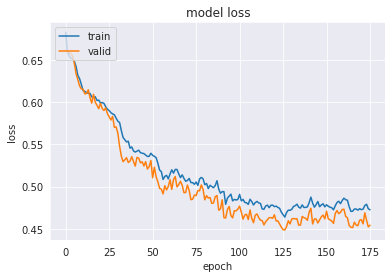

In [21]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')
            
            

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

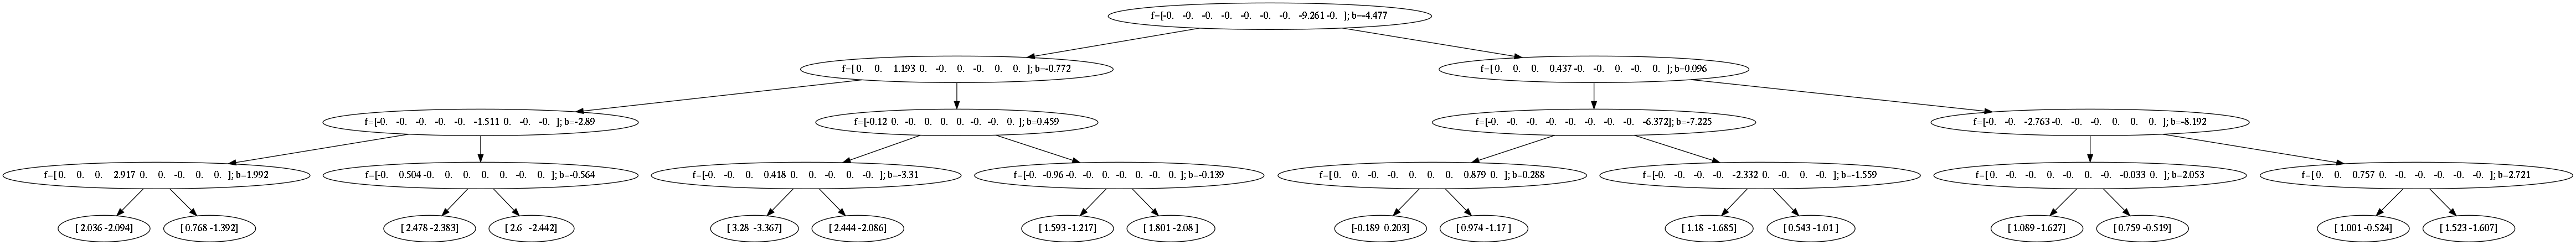

In [22]:
index = 3
network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1409)]       0                                            
__________________________________________________________________________________________________
hidden1_1024 (Dense)            (None, 1024)         1443840     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 1024)         0           hidden1_1024[0][0]               
__________________________________________________________________________________________________
dropout1_0.3 (Dropout)          (None, 1024)         0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [ ]:
with tf.device('/CPU:0'):
    number = min(lambda_net_dataset_train.X_test_lambda_array.shape[0], 100)

    start_inet = time.time() 
    
    network_parameters = np.array(lambda_net_dataset_train.network_parameters_array[:number])
    if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
    elif config['i_net']['data_reshape_version'] == 3: #autoencoder
        network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
    dt_inet_list = model.predict(network_parameters)   
    
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    

    
    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=10, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_train.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_train.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict_train = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict_train == None:
            inet_evaluation_result_dict_train = some_dict
        else:
            inet_evaluation_result_dict_train = mergeDict(inet_evaluation_result_dict_train, some_dict)

    inet_evaluation_result_dict_train['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean_train = {}

    for key_l1, values_l1 in inet_evaluation_result_dict_train.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean_train[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean_train[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean_train[key_l1][key_l2 + '_median'] = np.median(values_l2)
 

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  3.5min
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:  6.6min
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:  9.8min
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed: 12.9min
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed: 18.0min
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed: 21.7min
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed: 31.1min
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed: 39.9min


In [ ]:
print('TRAIN DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)

In [ ]:
mean_train = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

z_score_aggregate_list = []
distance_to_initialization_aggregate_list = []
distance_to_sample_average_list = []
distance_to_sample_min_list = []
max_distance_to_neuron_average_list = []
max_distance_to_neuron_min_list = []

for network in tqdm(lambda_net_dataset_train.network_parameters_array[:100]):
    (z_score_aggregate, 
     distance_to_initialization_aggregate, 
     distance_to_sample_average, 
     distance_to_sample_min, 
     max_distance_to_neuron_average,
     max_distance_to_neuron_min) = calculate_network_distance(mean=mean_train, 
                                                               std=std_train, 
                                                               network_parameters=network, 
                                                               lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                               config=config)    
    z_score_aggregate_list.append(z_score_aggregate)
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)  
    max_distance_to_neuron_average_list.append(max_distance_to_neuron_average)
    max_distance_to_neuron_min_list.append(max_distance_to_neuron_min)
    
z_score_average_train = np.mean(z_score_aggregate_list)
distance_to_initialization_average_train = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_average_train = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average_train = np.mean(distance_to_sample_min_list)

max_distance_to_neuron_average_average_train = np.mean(max_distance_to_neuron_average_list)
max_distance_to_neuron_min_average_train = np.mean(max_distance_to_neuron_min_list)


In [ ]:
with tf.device('/CPU:0'):
    number = min(lambda_net_dataset_valid.X_test_lambda_array.shape[0], 100)

    start_inet = time.time() 
    
    network_parameters = np.array(lambda_net_dataset_valid.network_parameters_array[:number])
    if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
    elif config['i_net']['data_reshape_version'] == 3: #autoencoder
        network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
    dt_inet_list = model.predict(network_parameters)  
    
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    


    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=1, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_valid.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_valid.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict_valid = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict_valid == None:
            inet_evaluation_result_dict_valid = some_dict
        else:
            inet_evaluation_result_dict_valid = mergeDict(inet_evaluation_result_dict_valid, some_dict)

    inet_evaluation_result_dict_valid['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean_valid = {}

    for key_l1, values_l1 in inet_evaluation_result_dict_valid.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean_valid[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean_valid[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean_valid[key_l1][key_l2 + '_median'] = np.median(values_l2)
 

In [ ]:
print('VALID DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)

In [ ]:
z_score_aggregate_list = []
distance_to_initialization_aggregate_list = []
distance_to_sample_average_list = []
distance_to_sample_min_list = []
max_distance_to_neuron_average_list = []
max_distance_to_neuron_min_list = []

for network in tqdm(lambda_net_dataset_valid.network_parameters_array[:100]):
    (z_score_aggregate, 
     distance_to_initialization_aggregate, 
     distance_to_sample_average, 
     distance_to_sample_min, 
     max_distance_to_neuron_average,
     max_distance_to_neuron_min) = calculate_network_distance(mean=mean_train, 
                                                               std=std_train, 
                                                               network_parameters=network, 
                                                               lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                               config=config)    
    z_score_aggregate_list.append(z_score_aggregate)
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)  
    max_distance_to_neuron_average_list.append(max_distance_to_neuron_average)
    max_distance_to_neuron_min_list.append(max_distance_to_neuron_min)
    
z_score_average_valid = np.mean(z_score_aggregate_list)
distance_to_initialization_average_valid = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_average_valid = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average_valid = np.mean(distance_to_sample_min_list)

max_distance_to_neuron_average_average_valid = np.mean(max_distance_to_neuron_average_list)
max_distance_to_neuron_min_average_valid = np.mean(max_distance_to_neuron_min_list)


In [ ]:
with tf.device('/CPU:0'):
    number = lambda_net_dataset_test.X_test_lambda_array.shape[0]#10

    start_inet = time.time() 
    
    network_parameters = np.array(lambda_net_dataset_test.network_parameters_array[:number])
    if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
    elif config['i_net']['data_reshape_version'] == 3: #autoencoder
        network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
    dt_inet_list = model.predict(network_parameters)  
    
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    


    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=1, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_test.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_test.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict_test = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict_test == None:
            inet_evaluation_result_dict_test = some_dict
        else:
            inet_evaluation_result_dict_test = mergeDict(inet_evaluation_result_dict_test, some_dict)

    inet_evaluation_result_dict_test['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean_test = {}

    for key_l1, values_l1 in inet_evaluation_result_dict_test.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean_test[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean_test[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean_test[key_l1][key_l2 + '_median'] = np.median(values_l2)
 

In [ ]:
print('TEST DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)


In [ ]:
z_score_aggregate_list = []
distance_to_initialization_aggregate_list = []
distance_to_sample_average_list = []
distance_to_sample_min_list = []
max_distance_to_neuron_average_list = []
max_distance_to_neuron_min_list = []

for network in tqdm(lambda_net_dataset_test.network_parameters_array[:100]):
    (z_score_aggregate, 
     distance_to_initialization_aggregate, 
     distance_to_sample_average, 
     distance_to_sample_min, 
     max_distance_to_neuron_average,
     max_distance_to_neuron_min) = calculate_network_distance(mean=mean_train, 
                                                               std=std_train, 
                                                               network_parameters=network, 
                                                               lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                               config=config)    
    z_score_aggregate_list.append(z_score_aggregate)
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)  
    max_distance_to_neuron_average_list.append(max_distance_to_neuron_average)
    max_distance_to_neuron_min_list.append(max_distance_to_neuron_min)
    
z_score_average_test = np.mean(z_score_aggregate_list)
distance_to_initialization_average_test = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_average_test = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average_test = np.mean(distance_to_sample_min_list)

max_distance_to_neuron_average_average_test = np.mean(max_distance_to_neuron_average_list)
max_distance_to_neuron_min_average_test = np.mean(max_distance_to_neuron_min_list)


In [ ]:
tab = PrettyTable()
tab.field_names = ['Metric', 'Train', 'Train ', ' Train ', 'Valid', 'Valid ', ' Valid ', 'Test', 'Test ', ' Test ']
tab.add_rows(
    [
        ['Metric', 
         'Dist. (Random)', 'Dist.', 'I-Net', 
         'Dist. (Random)', 'Dist.', 'I-Net', 
         'Dist. (Random)', 'Dist.', 'I-Net'],
        ['Soft Binary Crossentropy (Mean)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy'], 3),
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['soft_binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy'], 3),
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['soft_binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy'], 3),
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['runtime'], 3),  
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['runtime'], 3),  
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['soft_binary_crossentropy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['soft_binary_crossentropy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['binary_crossentropy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['binary_crossentropy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['runtime_median'], 3),  
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['runtime_median'], 3),  
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)


In [ ]:
tab = PrettyTable()
tab.field_names = ['Measure', 'Train Data', 'Valid Data', 'Test Data']
tab.add_rows(
    [
        ['Average Z-Score (Sample to Train Data)', np.round(z_score_average_train, 3), np.round(z_score_average_valid, 3), np.round(z_score_average_test, 3)],
        ['Average Distance to Initialization', np.round(distance_to_initialization_average_train, 3), np.round(distance_to_initialization_average_valid, 3), np.round(distance_to_initialization_average_test, 3)],
        ['Average Mean Distance to Train Data', np.round(distance_to_sample_average_average_train, 3), np.round(distance_to_sample_average_average_valid, 3), np.round(distance_to_sample_average_average_test, 3)],
        ['Average Distance to closest Train Data Sample', np.round(distance_to_sample_min_average_train, 3), np.round(distance_to_sample_min_average_valid, 3), np.round(distance_to_sample_min_average_test, 3)],
        ['Average Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_average_average_train, 3), np.round(max_distance_to_neuron_average_average_valid, 3), np.round(max_distance_to_neuron_average_average_test, 3)],
        ['Minimum Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_min_average_train, 3), np.round(max_distance_to_neuron_min_average_valid, 3), np.round(max_distance_to_neuron_min_average_test, 3)],
    ]    
)
print(tab)

# REAL DATA EVALUATION

## ADULT DATASET

In [ ]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 



adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)

adult_data.head()

In [ ]:
adult_data.describe()

In [ ]:
adult_data.info()

In [ ]:
#adult_data['Workclass'][adult_data['Workclass'] != ' Private'] = 'Other'
#adult_data['Race'][adult_data['Race'] != ' White'] = 'Other'

#adult_data.head()

In [ ]:
features_select = [
                 "Sex",  #9 
                 "Race",  #8
                 "Workclass",  #1
                 "Age", #0
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 #"Country", #13 
                 'capital_gain'
                  ]

adult_data = adult_data[features_select]

categorical_features = ['Race', 'Workclass', 'Education', "Marital Status", "Occupation", "Relationship"]#[1, 2, 7]
ordinal_features = ['Sex', 'capital_gain']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(adult_data)

adult_data = transformer.transform(adult_data)
adult_data = pd.DataFrame(adult_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    adult_data[ordinal_feature] = OrdinalEncoder().fit_transform(adult_data[ordinal_feature].values.reshape(-1, 1)).flatten()

adult_data = adult_data.astype(np.float64)

    
X_data_adult = adult_data.drop(['capital_gain'], axis = 1)

y_data_adult = adult_data['capital_gain']

print(X_data_adult.shape)
X_data_adult.head()

In [ ]:
if X_data_adult.shape[1] > number_of_variables:
    #X_data_adult = X_data_adult.sample(n=number_of_variables,axis='columns')
    
    clf_adult = ExtraTreesClassifier(n_estimators=100,
                                      random_state=RANDOM_SEED)
    clf_adult = clf_adult.fit(X_data_adult, y_data_adult)

    selector_adult = SelectFromModel(clf_adult, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_adult.get_support()   
    X_data_adult = X_data_adult.loc[:,feature_idx]
else:
    for i in range(number_of_variables-X_data_adult.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_adult[column_name] = np.zeros(X_data_adult.shape[0])
X_data_adult.head()

In [ ]:
normalizer_list = []
for column_name in X_data_adult:
    scaler = MinMaxScaler()
    scaler.fit(X_data_adult[column_name].values.reshape(-1, 1))
    X_data_adult[column_name] = scaler.transform(X_data_adult[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_adult.head()

In [ ]:
y_data_adult

In [ ]:
X_train_adult_with_valid, X_test_adult, y_train_adult_with_valid, y_test_adult = train_test_split(X_data_adult, y_data_adult, train_size=0.8, random_state=RANDOM_SEED)
X_train_adult, X_valid_adult, y_train_adult, y_valid_adult = train_test_split(X_train_adult_with_valid, y_train_adult_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_adult.shape, y_train_adult.shape)
print(X_valid_adult.shape, y_valid_adult.shape)
print(X_test_adult.shape, y_test_adult.shape)

In [ ]:
true_labels = len(y_train_adult[y_train_adult >= 0.5 ]) 
false_labels = len(y_train_adult[y_train_adult < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_adult, y_train_adult = oversample.fit_resample(X_train_adult, y_train_adult)

    true_labels = len(y_train_adult[y_train_adult >= 0.5 ]) 
    false_labels = len(y_train_adult[y_train_adult < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

In [ ]:
with tf.device('/CPU:0'):

    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_adult = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_adult.fit(X_train_adult,
                                      y_train_adult, 
                                      epochs=config['lambda_net']['epochs_lambda'], 
                                      batch_size=config['lambda_net']['batch_lambda'], 
                                      callbacks=[early_stopping, PlotLossesKerasTF()],
                                      validation_data=(X_valid_adult, y_valid_adult),
                                      verbose=0)



In [ ]:
test_network_adult.summary()

In [ ]:
test_network_adult_parameters = shaped_network_parameters_to_array(test_network_adult.get_weights(), config)

start_inet = time.time() 

network_parameters = np.array([test_network_adult_parameters])
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
test_network_adult_dt_inet = model.predict(network_parameters)[0]    

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [ ]:
dataset_size_list = [1_000, 10_000, 100_000, 1_000_000, 'TRAIN_DATA']
    
results_adult_list = []
dt_distilled_adult_list = []
for dataset_size in dataset_size_list:
    
    if dataset_size == 'TRAIN_DATA': 
        results_adult, dt_distilled_adult = evaluate_interpretation_net_prediction_single_sample(test_network_adult_parameters, 
                                                                           test_network_adult_dt_inet,
                                                                           X_test_adult.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_adult.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_adult, dt_distilled_adult = evaluate_interpretation_net_prediction_single_sample(test_network_adult_parameters, 
                                                                           test_network_adult_dt_inet,
                                                                           X_test_adult.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_adult['inet_scores']['runtime'] = inet_runtime
    results_adult_list.append(results_adult)
    dt_distilled_adult_list.append(dt_distilled_adult)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_adult['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_adult['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_adult['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy',  np.round(results_adult['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_adult['dt_scores']['binary_crossentropy'], 3), np.round(results_adult['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_adult['dt_scores']['accuracy_data_random'], 3), np.round(results_adult['dt_scores']['accuracy'], 3), np.round(results_adult['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_adult['dt_scores']['f1_score_data_random'], 3), np.round(results_adult['dt_scores']['f1_score'], 3), np.round(results_adult['inet_scores']['f1_score'], 3)],
            ['Runtime',  np.round(results_adult['dt_scores']['runtime'], 3), np.round(results_adult['dt_scores']['runtime'], 3), np.round(results_adult['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             
        
adult_evaluation_result_dict = None
for some_dict in results_adult_list:
    if adult_evaluation_result_dict == None:
        adult_evaluation_result_dict = some_dict
    else:
        adult_evaluation_result_dict = mergeDict(adult_evaluation_result_dict, some_dict)

#adult_evaluation_result_dict['dataset_size'] = dataset_size_list
                

In [ ]:
print('Dataset Size:\t\t', dataset_size)
tab = PrettyTable()
tab.field_names = flatten_list(['Metric', [['Dist. (Random) ' + str(size), 'Dist. ' + str(size)] for size in dataset_size_list], 'I-Net'])
tab.add_rows(
    [
        #flatten_list(['Metric', [[fill('Distilled DT (Train/Random Data) ' + str(size), width=10), fill('Distilled DT (Test Data) ' + str(size), width=10)] for size in dataset_size_list_adult], fill('I-Net DT (Test Data)', width=10)]),
        flatten_list(['Soft Binary Crossentropy', 
                      [[np.round(result_dict['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['soft_binary_crossentropy'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['soft_binary_crossentropy'], 3)]),
        flatten_list(['Binary Crossentropy',  
                      [[np.round(result_dict['dt_scores']['binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['binary_crossentropy'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['binary_crossentropy'], 3)]),
        flatten_list(['Accuracy', 
                      [[np.round(result_dict['dt_scores']['accuracy_data_random'], 3), np.round(result_dict['dt_scores']['accuracy'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['accuracy'], 3)]),
        flatten_list(['F1 Score', 
                      [[np.round(result_dict['dt_scores']['f1_score_data_random'], 3), np.round(result_dict['dt_scores']['f1_score'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['f1_score'], 3)]),
        flatten_list(['Runtime',  
                      [[np.round(result_dict['dt_scores']['runtime'], 3), np.round(result_dict['dt_scores']['runtime'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['runtime'], 3)])
    ]    
)
print(tab)
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             


In [ ]:
(z_score_aggregate_adult, 
 distance_to_initialization_aggregate_adult, 
 distance_to_sample_average_adult, 
 distance_to_sample_min_adult,
 max_distance_to_neuron_average_adult,
 max_distance_to_neuron_min_adult) = calculate_network_distance(mean=mean_train, 
                                                       std=std_train, 
                                                       network_parameters=test_network_adult_parameters, 
                                                       lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                       config=config)

In [ ]:
tab = PrettyTable()
tab.field_names = ['Measure', 'Train Data', 'Valid Data', 'Test Data', 'Adult Data']
tab.add_rows(
    [
        ['Average Z-Score (Sample to Train Data)', np.round(z_score_average_train, 3), np.round(z_score_average_valid, 3), np.round(z_score_average_test, 3), np.round(z_score_aggregate_adult, 3)],
        ['Average Distance to Initialization', np.round(distance_to_initialization_average_train, 3), np.round(distance_to_initialization_average_valid, 3), np.round(distance_to_initialization_average_test, 3), np.round(distance_to_initialization_aggregate_adult, 3)],
        ['Average Mean Distance to Train Data', np.round(distance_to_sample_average_average_train, 3), np.round(distance_to_sample_average_average_valid, 3), np.round(distance_to_sample_average_average_test, 3), np.round(distance_to_sample_average_adult, 3)],
        ['Average Distance to closest Train Data Sample', np.round(distance_to_sample_min_average_train, 3), np.round(distance_to_sample_min_average_valid, 3), np.round(distance_to_sample_min_average_test, 3), np.round(distance_to_sample_min_adult, 3)],
        ['Average Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_average_average_train, 3), np.round(max_distance_to_neuron_average_average_valid, 3), np.round(max_distance_to_neuron_average_average_test, 3), np.round(max_distance_to_neuron_average_adult, 3)],
        ['Minimum Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_min_average_train, 3), np.round(max_distance_to_neuron_min_average_valid, 3), np.round(max_distance_to_neuron_min_average_test, 3), np.round(max_distance_to_neuron_min_adult, 3)],           
    ]    
)
print(tab)

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_adult_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_adult_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_adult, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_adult.plot_tree()
image

## Titanic Dataset

In [ ]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data.head()

In [ ]:
titanic_data.describe()

In [ ]:
titanic_data.info()

In [ ]:
titanic_data = titanic_data.drop([
                                    'Cabin', 
                                    'Ticket', 
                                    'Name', 
                                    'PassengerId'
                                ], axis = 1)


In [ ]:
titanic_data.isnull().sum()

In [ ]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)
titanic_data.head()

    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
features_select = [
                    'Sex',    
                    'Embarked',
                    'Pclass',
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

categorical_features = ['Embarked']#[1, 2, 7]
ordinal_features = ['Sex']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(titanic_data)

titanic_data = transformer.transform(titanic_data)
titanic_data = pd.DataFrame(titanic_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    titanic_data[ordinal_feature] = OrdinalEncoder().fit_transform(titanic_data[ordinal_feature].values.reshape(-1, 1)).flatten()

titanic_data = titanic_data.astype(np.float64)

    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']

print(X_data_titanic.shape)
X_data_titanic.head()

    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
if X_data_titanic.shape[1] > number_of_variables:
    #X_data_titanic = X_data_titanic.sample(n=number_of_variables,axis='columns')
    
    clf_titanic = ExtraTreesClassifier(n_estimators=100,
                                      random_state=RANDOM_SEED)
    clf_titanic = clf_titanic.fit(X_data_titanic, y_data_titanic)

    selector_titanic = SelectFromModel(clf_titanic, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_titanic.get_support()   
    X_data_titanic = X_data_titanic.loc[:,feature_idx]    
else:
    for i in range(number_of_variables-X_data_titanic.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_titanic[column_name] = np.zeros(X_data_titanic.shape[0])
X_data_titanic.head()

In [ ]:
normalizer_list = []
for column_name in X_data_titanic:
    scaler = MinMaxScaler()
    scaler.fit(X_data_titanic[column_name].values.reshape(-1, 1))
    X_data_titanic[column_name] = scaler.transform(X_data_titanic[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_titanic.head()

In [ ]:
y_data_titanic

In [ ]:
X_train_titanic_with_valid, X_test_titanic, y_train_titanic_with_valid, y_test_titanic = train_test_split(X_data_titanic, y_data_titanic, train_size=0.8, random_state=RANDOM_SEED)
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X_train_titanic_with_valid, y_train_titanic_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_titanic.shape, y_train_titanic.shape)
print(X_valid_titanic.shape, y_valid_titanic.shape)
print(X_test_titanic.shape, y_test_titanic.shape)

In [ ]:
true_labels = len(y_train_titanic[y_train_titanic >= 0.5 ]) 
false_labels = len(y_train_titanic[y_train_titanic < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_titanic, y_train_titanic = oversample.fit_resample(X_train_titanic, y_train_titanic)

    true_labels = len(y_train_titanic[y_train_titanic >= 0.5 ]) 
    false_labels = len(y_train_titanic[y_train_titanic < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

In [ ]:
with tf.device('/CPU:0'):

    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_titanic = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_titanic.fit(X_train_titanic,
                                          y_train_titanic, 
                                          epochs=config['lambda_net']['epochs_lambda'], 
                                          batch_size=config['lambda_net']['batch_lambda'], 
                                          callbacks=[early_stopping, PlotLossesKerasTF()],
                                          validation_data=(X_valid_titanic, y_valid_titanic),
                                          verbose=0)



In [ ]:
test_network_titanic.summary()

In [ ]:
test_network_titanic_parameters = shaped_network_parameters_to_array(test_network_titanic.get_weights(), config)

start_inet = time.time() 

network_parameters = np.array([test_network_titanic_parameters])
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
test_network_titanic_dt_inet = model.predict(network_parameters)[0]    

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [ ]:
results_titanic_list = []
dt_distilled_titanic_list = []
for dataset_size in dataset_size_list:
    
    if dataset_size == 'TRAIN_DATA': 
        results_titanic, dt_distilled_titanic = evaluate_interpretation_net_prediction_single_sample(test_network_titanic_parameters, 
                                                                           test_network_titanic_dt_inet,
                                                                           X_test_titanic.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_titanic.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_titanic, dt_distilled_titanic = evaluate_interpretation_net_prediction_single_sample(test_network_titanic_parameters, 
                                                                           test_network_titanic_dt_inet,
                                                                           X_test_titanic.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_titanic['inet_scores']['runtime'] = inet_runtime
    results_titanic_list.append(results_titanic)
    dt_distilled_titanic_list.append(dt_distilled_titanic)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_titanic['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_titanic['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_titanic['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy', np.round(results_titanic['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_titanic['dt_scores']['binary_crossentropy'], 3), np.round(results_titanic['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_titanic['dt_scores']['accuracy_data_random'], 3), np.round(results_titanic['dt_scores']['accuracy'], 3), np.round(results_titanic['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_titanic['dt_scores']['f1_score_data_random'], 3), np.round(results_titanic['dt_scores']['f1_score'], 3), np.round(results_titanic['inet_scores']['f1_score'], 3)],
            ['Runtime',  np.round(results_titanic['dt_scores']['runtime'], 3), np.round(results_titanic['dt_scores']['runtime'], 3), np.round(results_titanic['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')        
        
titanic_evaluation_result_dict = None
for some_dict in results_titanic_list:
    if titanic_evaluation_result_dict == None:
        titanic_evaluation_result_dict = some_dict
    else:
        titanic_evaluation_result_dict = mergeDict(titanic_evaluation_result_dict, some_dict)

#titanic_evaluation_result_dict['dataset_size'] = dataset_size_list
                

In [ ]:
print('Dataset Size:\t\t', dataset_size)
tab = PrettyTable()
tab.field_names = flatten_list(['Metric', [['Dist. (Random) ' + str(size), 'Dist. ' + str(size)] for size in dataset_size_list], 'I-Net'])
tab.add_rows(
    [
        #flatten_list(['Metric', [[fill('Distilled DT (Train/Random Data) ' + str(size), width=10), fill('Distilled DT (Test Data) ' + str(size), width=10)] for size in dataset_size_list_adult], fill('I-Net DT (Test Data)', width=10)]),
        flatten_list(['Soft Binary Crossentropy', 
                      [[np.round(result_dict['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['soft_binary_crossentropy'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['soft_binary_crossentropy'], 3)]),
        flatten_list(['Binary Crossentropy',  
                      [[np.round(result_dict['dt_scores']['binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['binary_crossentropy'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['binary_crossentropy'], 3)]),
        flatten_list(['Accuracy', 
                      [[np.round(result_dict['dt_scores']['accuracy_data_random'], 3), np.round(result_dict['dt_scores']['accuracy'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['accuracy'], 3)]),
        flatten_list(['F1 Score', 
                      [[np.round(result_dict['dt_scores']['f1_score_data_random'], 3), np.round(result_dict['dt_scores']['f1_score'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['f1_score'], 3)]),
        flatten_list(['Runtime',  
                      [[np.round(result_dict['dt_scores']['runtime'], 3), np.round(result_dict['dt_scores']['runtime'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['runtime'], 3)])
    ]    
)
print(tab)
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             


In [ ]:
(z_score_aggregate_titanic, 
 distance_to_initialization_aggregate_titanic, 
 distance_to_sample_average_titanic, 
 distance_to_sample_min_titanic,
 max_distance_to_neuron_average_titanic,
 max_distance_to_neuron_min_titanic) = calculate_network_distance(mean=mean_train, 
                                                       std=std_train, 
                                                       network_parameters=test_network_titanic_parameters, 
                                                       lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                       config=config)

In [ ]:
tab = PrettyTable()
tab.field_names = ['Measure', 'Train Data', 'Valid Data', 'Test Data', 'Adult Data', 'Titanic Data']
tab.add_rows(
    [
        ['Average Z-Score (Sample to Train Data)', np.round(z_score_average_train, 3), np.round(z_score_average_valid, 3), np.round(z_score_average_test, 3), np.round(z_score_aggregate_adult, 3), np.round(z_score_aggregate_titanic, 3)],
        ['Average Distance to Initialization', np.round(distance_to_initialization_average_train, 3), np.round(distance_to_initialization_average_valid, 3), np.round(distance_to_initialization_average_test, 3), np.round(distance_to_initialization_aggregate_adult, 3), np.round(distance_to_initialization_aggregate_titanic, 3)],
        ['Average Mean Distance to Train Data', np.round(distance_to_sample_average_average_train, 3), np.round(distance_to_sample_average_average_valid, 3), np.round(distance_to_sample_average_average_test, 3), np.round(distance_to_sample_average_adult, 3), np.round(distance_to_sample_average_titanic, 3)],
        ['Average Distance to closest Train Data Sample', np.round(distance_to_sample_min_average_train, 3), np.round(distance_to_sample_min_average_valid, 3), np.round(distance_to_sample_min_average_test, 3), np.round(distance_to_sample_min_adult, 3), np.round(distance_to_sample_min_titanic, 3)],
        ['Average Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_average_average_train, 3), np.round(max_distance_to_neuron_average_average_valid, 3), np.round(max_distance_to_neuron_average_average_test, 3), np.round(max_distance_to_neuron_average_adult, 3), np.round(max_distance_to_neuron_average_titanic, 3)],
        ['Minimum Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_min_average_train, 3), np.round(max_distance_to_neuron_min_average_valid, 3), np.round(max_distance_to_neuron_min_average_test, 3), np.round(max_distance_to_neuron_min_adult, 3), np.round(max_distance_to_neuron_min_titanic, 3)],           
    ]    
)
print(tab)

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_titanic_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_titanic_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_titanic, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_titanic.plot_tree()
image

## Absenteeism at Work Dataset

In [ ]:
absenteeism_data = pd.read_csv('real_world_datasets/Absenteeism/absenteeism.csv', delimiter=';')

absenteeism_data.head()

In [ ]:
absenteeism_data.describe()

In [ ]:
absenteeism_data.info()

In [ ]:
absenteeism_data.isnull().sum()

In [ ]:
features_select = [
                           'Disciplinary failure', #CATEGORICAL
                           'Social drinker', #CATEGORICAL
                           'Social smoker', #CATEGORICAL
                           'Transportation expense', 
                           'Distance from Residence to Work',
                           'Service time', 
                           'Age', 
                           'Work load Average/day ', 
                           'Hit target',
                           'Education', 
                           'Son', 
                           'Pet', 
                           'Weight', 
                           'Height', 
                           'Body mass index', 
                           'Absenteeism time in hours'
                        ]

absenteeism_data = absenteeism_data[features_select]

categorical_features = []#[1, 2, 7]
ordinal_features = []

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(absenteeism_data)

absenteeism_data = transformer.transform(absenteeism_data)
absenteeism_data = pd.DataFrame(absenteeism_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    absenteeism_data[ordinal_feature] = OrdinalEncoder().fit_transform(absenteeism_data[ordinal_feature].values.reshape(-1, 1)).flatten()

absenteeism_data = absenteeism_data.astype(np.float64)

    
X_data_absenteeism = absenteeism_data.drop(['Absenteeism time in hours'], axis = 1)
y_data_absenteeism = ((absenteeism_data['Absenteeism time in hours'] > 4) * 1) #absenteeism_data['Absenteeism time in hours']

print(X_data_absenteeism.shape)
X_data_absenteeism.head()

    3. Month of absence
    4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
    5. Seasons (summer (1), autumn (2), winter (3), spring (4))
    6. Transportation expense
    7. Distance from Residence to Work (kilometers)
    8. Service time
    9. Age
    10. Work load Average/day
    11. Hit target
    12. Disciplinary failure (yes=1; no=0)
    13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
    14. Son (number of children)
    15. Social drinker (yes=1; no=0)
    16. Social smoker (yes=1; no=0)
    17. Pet (number of pet)
    18. Weight
    19. Height
    20. Body mass index
    21. Absenteeism time in hours (target)

In [ ]:
if X_data_absenteeism.shape[1] > number_of_variables:
    #X_data_absenteeism = X_data_absenteeism.sample(n=number_of_variables,axis='columns')
    
    clf_absenteeism = ExtraTreesClassifier(n_estimators=100,
                                          random_state=RANDOM_SEED)
    clf_absenteeism = clf_absenteeism.fit(X_data_absenteeism, y_data_absenteeism)

    selector_absenteeism = SelectFromModel(clf_absenteeism, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_absenteeism.get_support()   
    X_data_absenteeism = X_data_absenteeism.loc[:,feature_idx]        
else:
    for i in range(number_of_variables-X_data_absenteeism.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_absenteeism[column_name] = np.zeros(X_data_absenteeism.shape[0])
X_data_absenteeism.head()

In [ ]:
normalizer_list = []
for column_name in X_data_absenteeism:
    scaler = MinMaxScaler()
    scaler.fit(X_data_absenteeism[column_name].values.reshape(-1, 1))
    X_data_absenteeism[column_name] = scaler.transform(X_data_absenteeism[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_absenteeism.head()

In [ ]:
y_data_absenteeism

In [ ]:
X_train_absenteeism_with_valid, X_test_absenteeism, y_train_absenteeism_with_valid, y_test_absenteeism = train_test_split(X_data_absenteeism, y_data_absenteeism, train_size=0.8, random_state=RANDOM_SEED)
X_train_absenteeism, X_valid_absenteeism, y_train_absenteeism, y_valid_absenteeism = train_test_split(X_train_absenteeism_with_valid, y_train_absenteeism_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_absenteeism.shape, y_train_absenteeism.shape)
print(X_valid_absenteeism.shape, y_valid_absenteeism.shape)
print(X_test_absenteeism.shape, y_test_absenteeism.shape)

In [ ]:
true_labels = len(y_train_absenteeism[y_train_absenteeism >= 0.5 ]) 
false_labels = len(y_train_absenteeism[y_train_absenteeism < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_absenteeism, y_train_absenteeism = oversample.fit_resample(X_train_absenteeism, y_train_absenteeism)

    true_labels = len(y_train_absenteeism[y_train_absenteeism >= 0.5 ]) 
    false_labels = len(y_train_absenteeism[y_train_absenteeism < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

In [ ]:
with tf.device('/CPU:0'):
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_absenteeism = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_absenteeism.fit(X_train_absenteeism,
                                      y_train_absenteeism, 
                                      epochs=config['lambda_net']['epochs_lambda'], 
                                      batch_size=config['lambda_net']['batch_lambda'], 
                                      callbacks=[early_stopping, PlotLossesKerasTF()],
                                      validation_data=(X_valid_absenteeism, y_valid_absenteeism),
                                      verbose=0)



In [ ]:
test_network_absenteeism.summary()

In [ ]:
test_network_absenteeism_parameters = shaped_network_parameters_to_array(test_network_absenteeism.get_weights(), config)

start_inet = time.time() 

network_parameters = np.array([test_network_absenteeism_parameters])
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
test_network_absenteeism_dt_inet = model.predict(network_parameters)[0]  

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [ ]:
results_absenteeism_list = []
dt_distilled_absenteeism_list = []
for dataset_size in dataset_size_list:
    
    if dataset_size == 'TRAIN_DATA': 
        results_absenteeism, dt_distilled_absenteeism = evaluate_interpretation_net_prediction_single_sample(test_network_absenteeism_parameters, 
                                                                           test_network_absenteeism_dt_inet,
                                                                           X_test_absenteeism.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_absenteeism.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_absenteeism, dt_distilled_absenteeism = evaluate_interpretation_net_prediction_single_sample(test_network_absenteeism_parameters, 
                                                                           test_network_absenteeism_dt_inet,
                                                                           X_test_absenteeism.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_absenteeism['inet_scores']['runtime'] = inet_runtime
    results_absenteeism_list.append(results_absenteeism)
    dt_distilled_absenteeism_list.append(dt_distilled_absenteeism)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_absenteeism['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_absenteeism['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_absenteeism['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy', np.round(results_absenteeism['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_absenteeism['dt_scores']['binary_crossentropy'], 3), np.round(results_absenteeism['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_absenteeism['dt_scores']['accuracy_data_random'], 3), np.round(results_absenteeism['dt_scores']['accuracy'], 3), np.round(results_absenteeism['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_absenteeism['dt_scores']['f1_score_data_random'], 3), np.round(results_absenteeism['dt_scores']['f1_score'], 3), np.round(results_absenteeism['inet_scores']['f1_score'], 3)],
            ['Runtime', np.round(results_absenteeism['dt_scores']['runtime'], 3), np.round(results_absenteeism['dt_scores']['runtime'], 3), np.round(results_absenteeism['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')        

    
absenteeism_evaluation_result_dict = None
for some_dict in results_absenteeism_list:
    if absenteeism_evaluation_result_dict == None:
        absenteeism_evaluation_result_dict = some_dict
    else:
        absenteeism_evaluation_result_dict = mergeDict(absenteeism_evaluation_result_dict, some_dict)

#absenteeism_evaluation_result_dict['dataset_size'] = dataset_size_list
                

In [ ]:
print('Dataset Size:\t\t', dataset_size)
tab = PrettyTable()
tab.field_names = flatten_list(['Metric', [['Dist. (Random) ' + str(size), 'Dist. ' + str(size)] for size in dataset_size_list], 'I-Net'])
tab.add_rows(
    [
        #flatten_list(['Metric', [[fill('Distilled DT (Train/Random Data) ' + str(size), width=10), fill('Distilled DT (Test Data) ' + str(size), width=10)] for size in dataset_size_list_adult], fill('I-Net DT (Test Data)', width=10)]),
        flatten_list(['Soft Binary Crossentropy', 
                      [[np.round(result_dict['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['soft_binary_crossentropy'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['soft_binary_crossentropy'], 3)]),
        flatten_list(['Binary Crossentropy',  
                      [[np.round(result_dict['dt_scores']['binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['binary_crossentropy'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['binary_crossentropy'], 3)]),
        flatten_list(['Accuracy', 
                      [[np.round(result_dict['dt_scores']['accuracy_data_random'], 3), np.round(result_dict['dt_scores']['accuracy'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['accuracy'], 3)]),
        flatten_list(['F1 Score', 
                      [[np.round(result_dict['dt_scores']['f1_score_data_random'], 3), np.round(result_dict['dt_scores']['f1_score'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['f1_score'], 3)]),
        flatten_list(['Runtime',  
                      [[np.round(result_dict['dt_scores']['runtime'], 3), np.round(result_dict['dt_scores']['runtime'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['runtime'], 3)])
    ]    
)
print(tab)
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             


In [ ]:
(z_score_aggregate_absenteeism, 
 distance_to_initialization_aggregate_absenteeism, 
 distance_to_sample_average_absenteeism, 
 distance_to_sample_min_absenteeism,
 max_distance_to_neuron_average_absenteeism,
 max_distance_to_neuron_min_absenteeism) = calculate_network_distance(mean=mean_train, 
                                                       std=std_train, 
                                                       network_parameters=test_network_absenteeism_parameters, 
                                                       lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                       config=config)

In [ ]:
tab = PrettyTable()
tab.field_names = ['Measure', 'Train Data', 'Valid Data', 'Test Data', 'Adult Data', 'Titanic Data', 'Absenteeism Data']
tab.add_rows(
    [
        ['Average Z-Score (Sample to Train Data)', np.round(z_score_average_train, 3), np.round(z_score_average_valid, 3), np.round(z_score_average_test, 3), np.round(z_score_aggregate_adult, 3), np.round(z_score_aggregate_titanic, 3), np.round(z_score_aggregate_absenteeism, 3)],
        ['Average Distance to Initialization', np.round(distance_to_initialization_average_train, 3), np.round(distance_to_initialization_average_valid, 3), np.round(distance_to_initialization_average_test, 3), np.round(distance_to_initialization_aggregate_adult, 3), np.round(distance_to_initialization_aggregate_titanic, 3), np.round(distance_to_initialization_aggregate_absenteeism, 3)],
        ['Average Mean Distance to Train Data', np.round(distance_to_sample_average_average_train, 3), np.round(distance_to_sample_average_average_valid, 3), np.round(distance_to_sample_average_average_test, 3), np.round(distance_to_sample_average_adult, 3), np.round(distance_to_sample_average_titanic, 3), np.round(distance_to_sample_average_absenteeism, 3)],
        ['Average Distance to closest Train Data Sample', np.round(distance_to_sample_min_average_train, 3), np.round(distance_to_sample_min_average_valid, 3), np.round(distance_to_sample_min_average_test, 3), np.round(distance_to_sample_min_adult, 3), np.round(distance_to_sample_min_titanic, 3), np.round(distance_to_sample_min_absenteeism, 3)],
        ['Average Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_average_average_train, 3), np.round(max_distance_to_neuron_average_average_valid, 3), np.round(max_distance_to_neuron_average_average_test, 3), np.round(max_distance_to_neuron_average_adult, 3), np.round(max_distance_to_neuron_average_titanic, 3), np.round(max_distance_to_neuron_average_absenteeism, 3)],
        ['Minimum Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_min_average_train, 3), np.round(max_distance_to_neuron_min_average_valid, 3), np.round(max_distance_to_neuron_min_average_test, 3), np.round(max_distance_to_neuron_min_adult, 3), np.round(max_distance_to_neuron_min_titanic, 3), np.round(max_distance_to_neuron_min_absenteeism, 3)],        
    ]    
)
print(tab)

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_absenteeism_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_absenteeism_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_absenteeism, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_absenteeism.plot_tree()
image

In [ ]:
dataset_size = 10000

print('Dataset Size:\t\t', dataset_size)
tab = PrettyTable()
tab.field_names = ['Metric', 
                   #'Dist. (Random) Adult', 
                   'Dist. Adult', 
                   'I-Net Adult',
                   #'Dist. (Random) Titanic', 
                   'Dist. Titanic', 
                   'I-Net Titanic',                   
                   #'Dist. (Random) Absent.', 
                   'Dist. Absent.', 
                   'I-Net Absent.',
                  ]
tab.add_rows(
    [
        #flatten_list(['Metric', [[fill('Distilled DT (Train/Random Data) ' + str(size), width=10), fill('Distilled DT (Test Data) ' + str(size), width=10)] for size in dataset_size_list_adult], fill('I-Net DT (Test Data)', width=10)]),
        flatten_list(['Soft BC', 
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['soft_binary_crossentropy'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['soft_binary_crossentropy'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['soft_binary_crossentropy'], 3),                      
                      ]),
        flatten_list(['BC',  
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_data_random'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['binary_crossentropy'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_data_random'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['binary_crossentropy'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_data_random'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['binary_crossentropy'], 3),                       
                     ]),
        flatten_list(['Acc', 
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_data_random'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['accuracy'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_data_random'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['accuracy'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_data_random'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['accuracy'], 3),      
                     ]),
        flatten_list(['F1 Score', 
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_data_random'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['f1_score'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_data_random'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['f1_score'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_data_random'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['f1_score'], 3),                            
                     ]),
        flatten_list(['Runtime',  
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['runtime'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['runtime'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['runtime'], 3),                            
                     ])
    ]    
)
print(tab)
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             


In [ ]:
writepath_complete = './results_complete.csv'
writepath_summary = './results_summary.csv'

#TODO: ADD COMPLEXITY FOR DTS

if different_eval_data:
    flat_config = flatten_dict(config_train)
else:
    flat_config = flatten_dict(config)    

flat_dict_train = flatten_dict(inet_evaluation_result_dict_train)
flat_dict_valid = flatten_dict(inet_evaluation_result_dict_valid)
flat_dict_test = flatten_dict(inet_evaluation_result_dict_test)


#TODO ADD FUNCTION VALUES FOR EACH DATASET SIZE (IN SEPARATE FILE?)
#    - COLLECT ERRORS PER NETWORK / FIND FILE WHERE SAVED

if not os.path.exists(writepath_complete):
    with open(writepath_complete, 'w+') as text_file:       
        for key in flat_config.keys():
            text_file.write(key)
            text_file.write(';')      
        
        number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_train.keys():
            if 'function_values' not in key:
                for i in range(number_of_evaluated_networks):
                    text_file.write(key + '_train_' + str(i) + ';')    
                    
        number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_valid.keys():
            if 'function_values' not in key:
                for i in range(number_of_evaluated_networks):
                    text_file.write(key + '_valid_' + str(i) + ';')       
                    
        number_of_evaluated_networks = np.array(flat_dict_test['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_test.keys():
            if 'function_values' not in key:
                for i in range(number_of_evaluated_networks):
                    text_file.write(key + '_test_' + str(i) + ';')        
        
        text_file.write('\n')
    
with open(writepath_complete, 'a+') as text_file:  
    for value in flat_config.values():
        text_file.write(str(value))
        text_file.write(';')
            
        
    number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_train.items():
        if 'function_values' not in key:
            for score in values:
                text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_valid.items():
        if 'function_values' not in key:
            for score in values:
                text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_test['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_test.items():
        if 'function_values' not in key:
            for score in values:
                text_file.write(str(score) + ';')   
                    
    text_file.write('\n')            

    text_file.close()  
    


In [ ]:
inet_evaluation_result_dict_mean_train_flat = flatten_dict(inet_evaluation_result_dict_mean_train)
inet_evaluation_result_dict_mean_valid_flat = flatten_dict(inet_evaluation_result_dict_mean_valid)
inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_test)
    
results_adult_flat = flatten_dict(results_adult)
del results_adult_flat['function_values_y_test_inet_dt']
del results_adult_flat['function_values_y_test_distilled_dt']

results_titanic_flat = flatten_dict(results_titanic)
del results_titanic_flat['function_values_y_test_inet_dt']
del results_titanic_flat['function_values_y_test_distilled_dt']

results_absenteeism_flat = flatten_dict(results_absenteeism)
del results_absenteeism_flat['function_values_y_test_inet_dt']
del results_absenteeism_flat['function_values_y_test_distilled_dt']

adult_evaluation_result_dict_flat = flatten_dict(adult_evaluation_result_dict)
del adult_evaluation_result_dict_flat['function_values_y_test_inet_dt']
del adult_evaluation_result_dict_flat['function_values_y_test_distilled_dt']
#del adult_evaluation_result_dict_flat['dataset_size']

titanic_evaluation_result_dict_flat = flatten_dict(titanic_evaluation_result_dict)
del titanic_evaluation_result_dict_flat['function_values_y_test_inet_dt']
del titanic_evaluation_result_dict_flat['function_values_y_test_distilled_dt']
#del titanic_evaluation_result_dict_flat['dataset_size']

absenteeism_evaluation_result_dict_flat = flatten_dict(absenteeism_evaluation_result_dict)
del absenteeism_evaluation_result_dict_flat['function_values_y_test_inet_dt']
del absenteeism_evaluation_result_dict_flat['function_values_y_test_distilled_dt']
#del absenteeism_evaluation_result_dict_flat['dataset_size']


if not os.path.exists(writepath_summary):
    with open(writepath_summary, 'w+') as text_file: 
            
        for key in flat_config.keys():
            text_file.write(key + ';')
         
        for key in inet_evaluation_result_dict_mean_train_flat.keys():
            text_file.write('train_' + key + ';')
        for key in inet_evaluation_result_dict_mean_valid_flat.keys():
            text_file.write('valid_' + key + ';')            
        for key in inet_evaluation_result_dict_mean_test_flat.keys():
            text_file.write('test_' + key + ';')
        
        for dataset_size in dataset_size_list:
            for key in results_adult_flat.keys():
                text_file.write(key + '_adult_' + str(dataset_size) + ';')
        
            for key in results_titanic_flat.keys():
                text_file.write(key + '_titanic_' + str(dataset_size) + ';')
                
            for key in results_absenteeism_flat.keys():
                text_file.write(key + '_absenteeism_' + str(dataset_size) + ';')    
         
        text_file.write('z-score_train' + ';')    
        text_file.write('z-score_valid' + ';')    
        text_file.write('z-score_test' + ';')    
        text_file.write('z-score_adult' + ';')    
        text_file.write('z-score_titanic' + ';')    
        text_file.write('z-score_absenteeism' + ';')    

        text_file.write('dist_to_init_train' + ';')    
        text_file.write('dist_to_init_valid' + ';')    
        text_file.write('dist_to_init_test' + ';')    
        text_file.write('dist_to_init_adult' + ';')    
        text_file.write('dist_to_init_titanic' + ';')    
        text_file.write('dist_to_init_absenteeism' + ';')    
        
        text_file.write('avg_dist_to_train_train' + ';')    
        text_file.write('avg_dist_to_train_valid' + ';')    
        text_file.write('avg_dist_to_train_test' + ';')    
        text_file.write('avg_dist_to_train_adult' + ';')    
        text_file.write('avg_dist_to_train_titanic' + ';')    
        text_file.write('avg_dist_to_train_absenteeism' + ';')    
        
        text_file.write('min_dist_to_train_sample_train' + ';')    
        text_file.write('min_dist_to_train_sample_valid' + ';')    
        text_file.write('min_dist_to_train_samplee_test' + ';')    
        text_file.write('min_dist_to_train_sample_adult' + ';')    
        text_file.write('min_dist_to_train_sample_titanic' + ';')    
        text_file.write('min_dist_to_train_sample_absenteeism')    
        
        text_file.write('\n')
    
with open(writepath_summary, 'a+') as text_file: 
    
    for value in flat_config.values():
        text_file.write(str(value) + ';')
        
    for value in inet_evaluation_result_dict_mean_train_flat.values():
        text_file.write(str(value) + ';')
    for value in inet_evaluation_result_dict_mean_valid_flat.values():
        text_file.write(str(value) + ';')            
    for value in inet_evaluation_result_dict_mean_test_flat.values():
        text_file.write(str(value) + ';')

    for i in range(len(dataset_size_list)):
        for values in adult_evaluation_result_dict_flat.values():
            text_file.write(str(values[i]) + ';')            

        for values in titanic_evaluation_result_dict_flat.values():
            text_file.write(str(values[i]) + ';')            

        for values in absenteeism_evaluation_result_dict_flat.values():
            text_file.write(str(values[i]) + ';')            
    
    text_file.write(str(z_score_average_train) + ';')    
    text_file.write(str(z_score_average_valid) + ';')    
    text_file.write(str(z_score_average_test) + ';')    
    text_file.write(str(z_score_aggregate_adult) + ';')    
    text_file.write(str(z_score_aggregate_titanic) + ';')    
    text_file.write(str(z_score_aggregate_absenteeism) + ';')    

    text_file.write(str(distance_to_initialization_average_train) + ';')    
    text_file.write(str(distance_to_initialization_average_valid) + ';')    
    text_file.write(str(distance_to_initialization_average_test) + ';')    
    text_file.write(str(distance_to_initialization_aggregate_adult) + ';')    
    text_file.write(str(distance_to_initialization_aggregate_titanic) + ';')    
    text_file.write(str(distance_to_initialization_aggregate_absenteeism) + ';')    

    text_file.write(str(distance_to_sample_average_average_train) + ';')    
    text_file.write(str(distance_to_sample_average_average_valid) + ';')    
    text_file.write(str(distance_to_sample_average_average_test) + ';')    
    text_file.write(str(distance_to_sample_average_adult) + ';')    
    text_file.write(str(distance_to_sample_average_titanic) + ';')    
    text_file.write(str(distance_to_sample_average_absenteeism) + ';')    

    text_file.write(str(distance_to_sample_min_average_train) + ';')    
    text_file.write(str(distance_to_sample_min_average_valid) + ';')    
    text_file.write(str(distance_to_sample_min_average_test) + ';')    
    text_file.write(str(distance_to_sample_min_adult) + ';')    
    text_file.write(str(distance_to_sample_min_titanic) + ';')    
    text_file.write(str(distance_to_sample_min_absenteeism))       
    
    text_file.write('\n')

    text_file.close()      

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

## NEXT DATASET